# Regression Problem

### 1. Import necessary libraries:

In [2]:
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from mltools.regression_tools import LinearRegressor
from mltools import regression_tools as RT

### 2. Load data as a Pandas DataFrame:

In [3]:
path_irrad = "../data/G07A_DATOS_IRRAD.csv"
df_orig_irrad = pd.read_csv(path_irrad)

# Parse the date (string) for it to be a datetime with format yyyy/mm/dd
df_orig_irrad['FECHA'] = pd.to_datetime(df_orig_irrad['FECHA'], format='%Y-%m-%d')

s = df_orig_irrad.loc[:,'FECHA']
df_orig_irrad['FECHA'] =  s.dt.date

In [4]:
path_util = "../data/G07A_DATOS_UTIL.csv"
df_orig_util = pd.read_csv(path_util)

# Parse the date (string) for it to be a datetime with format yyyy/mm/dd
df_orig_util['FECHA'] = pd.to_datetime(df_orig_util['FECHA'], format='%Y-%m-%d')

s = df_orig_util.loc[:,'FECHA']
df_orig_util['FECHA'] =  s.dt.date

In [5]:
df = pd.merge(df_orig_irrad, df_orig_util, on=['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM'] , how='inner')
df.head()

,FECHA,IRRADH00,IRRADH03,IRRADH06,IRRADH09,IRRADH12,IRRADH15,IRRADH18,IRRADH21,ANNO,...,DIA,DIASEM,UTILH00,UTILH03,UTILH06,UTILH09,UTILH12,UTILH15,UTILH18,UTILH21
0,2015-01-01,0.0,0.0,0.0,414536.22,1193085.20,481816.38,0.0,0.0,2015,...,1,3,0.0,0.0,0.027848,0.235443,0.263291,0.039241,0.0,0.0
1,2015-01-02,0.0,0.0,0.0,319990.20,926238.10,182854.10,0.0,0.0,2015,...,2,4,0.0,0.0,0.027848,0.181857,0.205063,0.024051,0.0,0.0
2,2015-01-03,0.0,0.0,0.0,403464.62,1146347.20,360073.94,0.0,0.0,2015,...,3,5,0.0,0.0,0.029536,0.237975,0.235865,0.036287,0.0,0.0
3,2015-01-04,0.0,0.0,0.0,349597.03,1016177.06,315783.62,0.0,0.0,2015,...,4,6,0.0,0.0,0.029114,0.196203,0.210970,0.026160,0.0,0.0
4,2015-01-05,0.0,0.0,0.0,408705.38,1090662.90,532075.10,0.0,0.0,2015,...,5,0,0.0,0.0,0.028270,0.205485,0.228270,0.036287,0.0,0.0


### 3. Split the data into training and test sets:

In [6]:
# Define input and output matrices:
INPUTS = ['IRRADH00', 'IRRADH03', 'IRRADH06', 'IRRADH09', 'IRRADH12',
          'IRRADH15', 'IRRADH18', 'IRRADH21', 'ANNO', 'MES', 'DIA', 'DIASEM']
OUTPUTS = ['UTILH00', 'UTILH03', 'UTILH06', 'UTILH09', 
          'UTILH12', 'UTILH15', 'UTILH18', 'UTILH21']

X = df[INPUTS]
Y = df[OUTPUTS]

# Split:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.3,  # Percentage of test data
                                                    random_state=0) # Seed for replication

In [8]:
# Create dataset to store model predictions:
dfTR_eval = X_train.copy()
dfTR_eval[OUTPUTS] = Y_train

dfTS_eval = X_test.copy()
dfTS_eval[OUTPUTS] = Y_test

### 4. Training of Linear Regression Models:

As it has been indicated that the solar utilization depends on irradiation from a given time interval, we will be considering separate linear regression models for each hour.

In [16]:
hours = ['00', '03', '06', '09', '12', '15', '18', '21']

# Initialize a dictionary to store the trained models for each hour
# and a second one to store the Cross-Validation scores for each trained model:
hourly_models   = {}
CV_score_hourly = {}
summary_hourly  = {}
metrics_hourly  = {}

# Train a linear regression model for each hour:
for hour in hours:

    # Define input and output features for the current hour:
    inputs_hourly = ['IRRADH' + hour, 'ANNO', 'MES', 'DIA', 'DIASEM']
    output_hourly = 'UTILH' + hour
    
    # Create input and output matrices for the current hour:
    X_train_hourly = X_train[inputs_hourly]
    y_train_hourly = Y_train[output_hourly]

    X_test_hourly  = X_test[inputs_hourly]
    
    # ----- 
    # -----

    # Train a linear regression model for the current hour:
    INPUTS_LR = inputs_hourly

    # Preparation of the numeric variables by scaling:
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

    # Creation of a preprocessor to perform the steps defined above:
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, INPUTS_LR)])

    # Establishment the Linear Regression Model within a Pipeline:
    LinReg_fit_h = Pipeline(steps=[('Prep',preprocessor), 
                        ('LinReg',LinearRegressor(fit_intercept=True))]) 

    # Train model:
    LinReg_fit_h.fit(X_train_hourly, y_train_hourly);
    
    # Store the trained model in the dictionary:
    hourly_models[hour] = LinReg_fit_h

    # ----- 
    # -----

    # Store Cross-Validation score:
    CV_score_h = cross_val_score(LinReg_fit_h, X_train_hourly, y_train_hourly, cv=10, scoring='neg_root_mean_squared_error').mean()
    CV_score_hourly[hour] = CV_score_h

    # -----
    # -----

    # Information about the model trained:
    summary_h = RT.summaryLinReg(LinReg_fit_h, X_train_hourly, y_train_hourly)
    summary_hourly[hour] = summary_h

    # -----
    # -----

    # Model performance metrics:
    dfTR_eval[output_hourly + '_pred'] = LinReg_fit_h.predict(X_train_hourly)
    dfTS_eval[output_hourly + '_pred'] = LinReg_fit_h.predict(X_test_hourly)

    # Training and test MAE - Mean Absolute error
    mae_tr_h = mean_absolute_error(dfTR_eval[output_hourly], dfTR_eval[output_hourly + '_pred'])
    mae_ts_h = mean_absolute_error(dfTS_eval[output_hourly], dfTS_eval[output_hourly + '_pred'])

    # Training and test RMSE - Root Mean Square Error
    rmse_tr_h = math.sqrt(mean_squared_error(dfTR_eval[output_hourly], dfTR_eval[output_hourly + '_pred']))
    rmse_ts_h = math.sqrt(mean_squared_error(dfTS_eval[output_hourly], dfTS_eval[output_hourly + '_pred']))

    # Training and test r^2 
    r2_tr_h = r2_score(dfTR_eval[output_hourly], dfTR_eval[output_hourly + '_pred'])
    r2_ts_h = r2_score(dfTS_eval[output_hourly], dfTS_eval[output_hourly + '_pred'])
    
    metrics_hourly[hour] = {'mae_tr_' + hour: mae_tr_h, 'mae_ts_' + hour: mae_ts_h,
                            'rmse_tr_' + hour: rmse_tr_h, 'rmse_ts_' + hour: rmse_ts_h,
                            'r2_tr_' + hour: r2_tr_h, 'r2_ts_' + hour: r2_ts_h} 

In [8]:
print("CV negative RMSE per time interval is:\n")
for key, value in CV_score_hourly.items():
    print(f"{key}: {value}")

CV negative RMSE per time interval is:

00: -0.0016302126706607086
03: -0.006360087538595756
06: -0.03768178725968737
09: -0.07104960836432125
12: -0.07232097189778289
15: -0.036281663767392766
18: -0.0035655914772534866
21: -0.0013063064756179488


In [9]:
print("Information about each model trained per time interval:\n")
for key, value in summary_hourly.items():
    print(f"{key}: {value}")

Information about each model trained per time interval:

00:                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     13.08
Date:                Fri, 29 Mar 2024   Prob (F-statistic):           1.79e-10
Time:                        10:20:53   Log-Likelihood:                 7521.2
No. Observations:                1534   AIC:                        -1.503e+04
Df Residuals:                    1529   BIC:                        -1.501e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [10]:
print("Mean Absolute Error per time interval:\n")
for key, value in metrics_hourly.items():
    print(f"{key}: {value}")

Mean Absolute Error per time interval:

00: {'mae_tr_00': 0.000969484055321099, 'mae_ts_00': 0.000994372133952528, 'rmse_tr_00': 0.0017964719972353908, 'rmse_ts_00': 0.0014260563522128205, 'r2_tr_00': 0.03307521521915102, 'r2_ts_00': 0.03532617155294571}
03: {'mae_tr_03': 0.00418413046720633, 'mae_ts_03': 0.003964369122859611, 'rmse_tr_03': 0.006354551771456234, 'rmse_ts_03': 0.005810475522118052, 'r2_tr_03': 0.2247348918672898, 'r2_ts_03': 0.21594727068388864}
06: {'mae_tr_06': 0.02992025372201826, 'mae_ts_06': 0.028956899892823212, 'rmse_tr_06': 0.03756401925762646, 'rmse_ts_06': 0.03718260963882308, 'r2_tr_06': 0.560292257034581, 'r2_ts_06': 0.578704586319022}
09: {'mae_tr_09': 0.05681786977568487, 'mae_ts_09': 0.05487154194119162, 'rmse_tr_09': 0.07086681981391836, 'rmse_ts_09': 0.06903484015228267, 'r2_tr_09': 0.6445938262804963, 'r2_ts_09': 0.6797630558462158}
12: {'mae_tr_12': 0.05572374234631118, 'mae_ts_12': 0.05388648080903992, 'rmse_tr_12': 0.0722182612413601, 'rmse_ts_12': 

c:\Users\belus\anaconda3\envs\Assessment1\Lib\site-packages\mltools\regression_tools.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['residuals'] = df[output_name] - df[pred]
c:\Users\belus\anaconda3\envs\Assessment1\Lib\site-packages\seaborn\regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


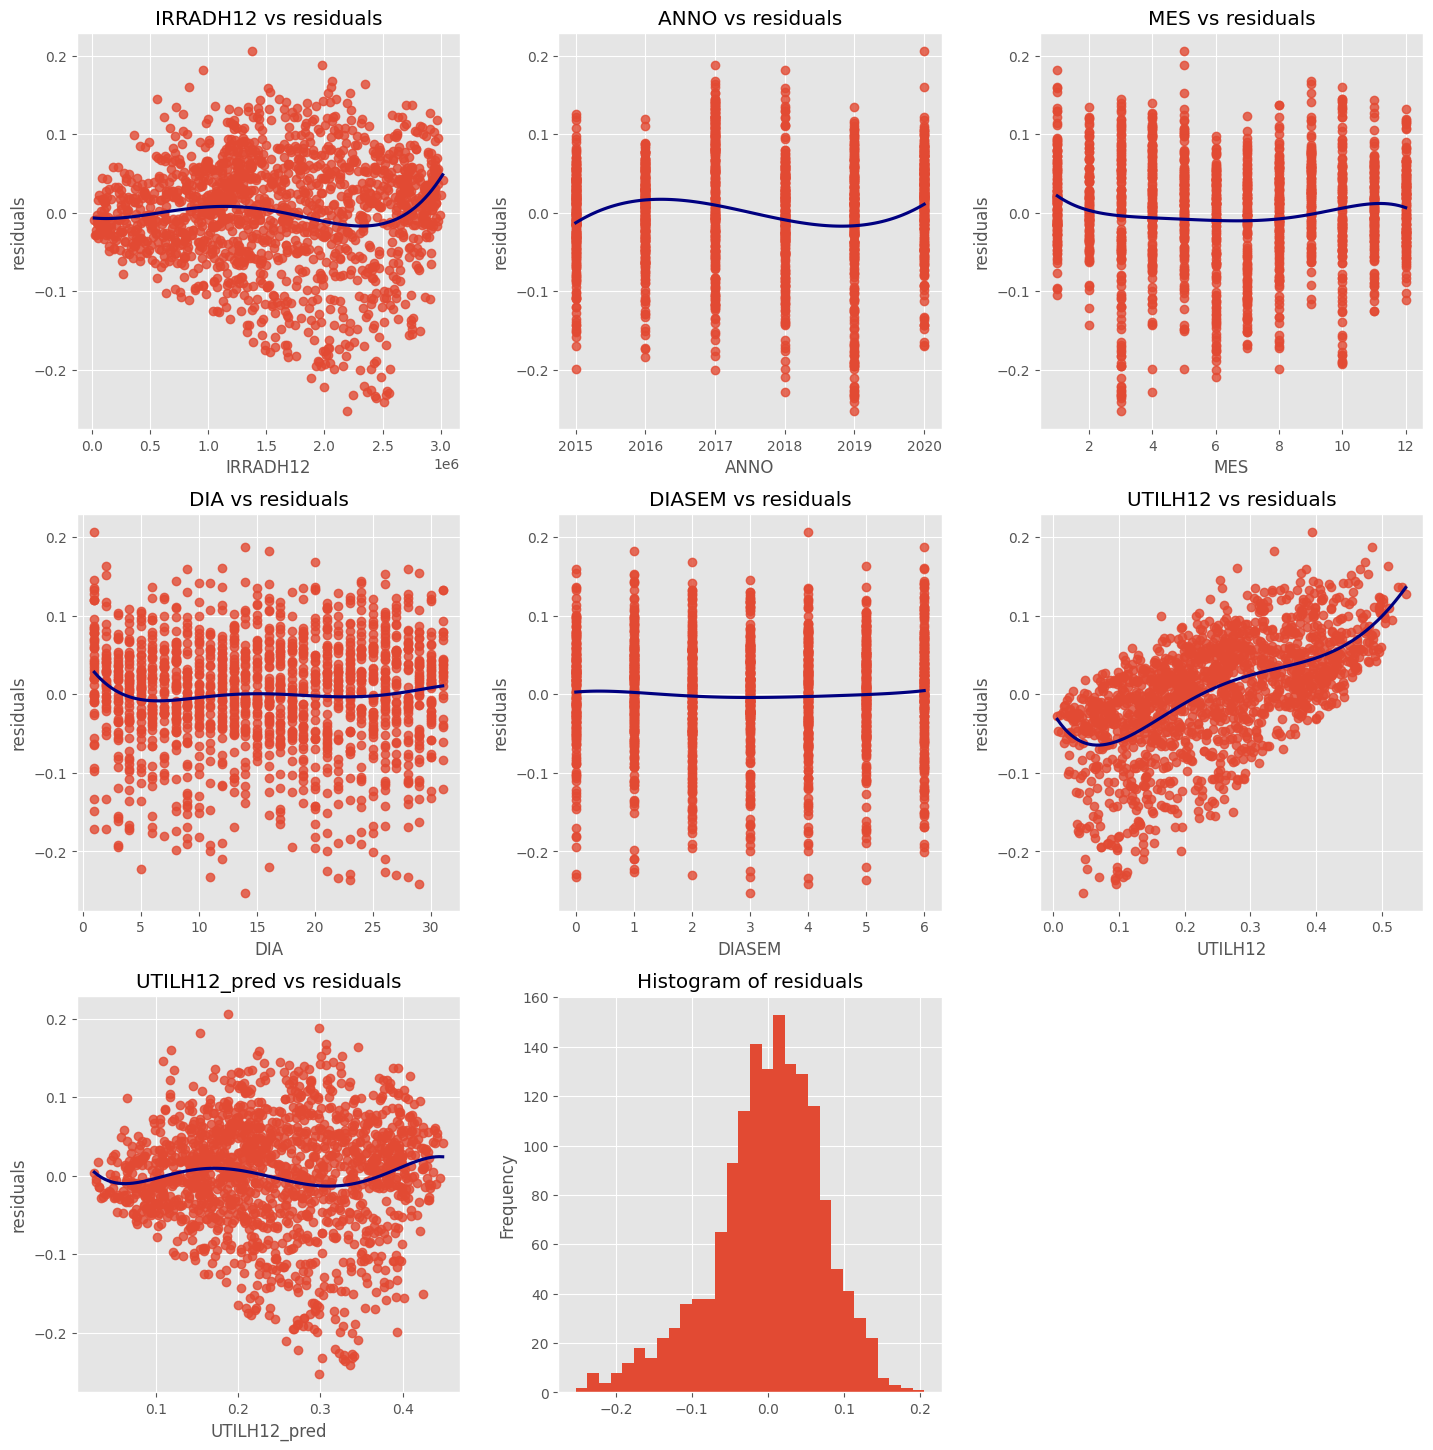

In [19]:
hours = ['12']

for hour in hours:
    inputs_hourly = ['IRRADH' + hour, 'ANNO', 'MES', 'DIA', 'DIASEM']
    output_hourly = 'UTILH' + hour
    pred_hourly   = output_hourly + '_pred'

    dfTR_eval_h = dfTR_eval[inputs_hourly + [output_hourly, pred_hourly]]

    # Analysis of residuals
    RT.plotModelDiagnosis(dfTR_eval_h, pred_hourly, output_hourly, figsize=[15,15])

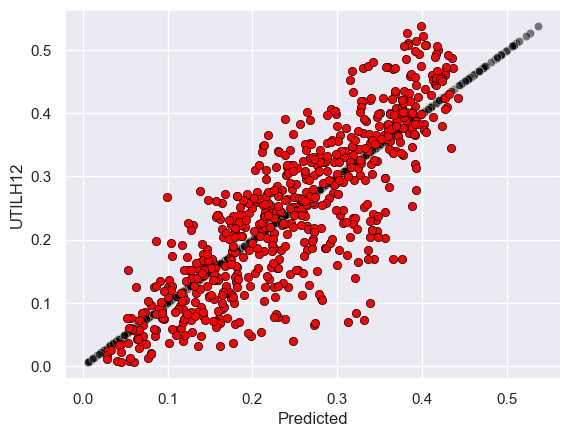

In [22]:
hours = ['12']

for hour in hours:
    inputs_hourly = ['IRRADH' + hour, 'ANNO', 'MES', 'DIA', 'DIASEM']
    output_hourly = 'UTILH' + hour
    pred_hourly   = output_hourly + '_pred'

    # Visualize prediction with respect to real value
    sns.scatterplot(data=dfTS_eval, x = output_hourly, y = output_hourly, color='black', alpha=0.5)
    sns.scatterplot(data=dfTS_eval, x = pred_hourly, y = output_hourly, color='red', edgecolor='black')
    plt.xlabel('Predicted')
    plt.show()

### 5. Training of Linear Regression Model with all IRRADHXX as inputs:

In [9]:
hours = ['00', '03', '06', '09', '12', '15', '18', '21']

# Initialize a dictionary to store the trained models for each hour
# and a second one to store the Cross-Validation scores for each trained model:
hourly_models   = {}
CV_score_hourly = {}
summary_hourly  = {}
metrics_hourly  = {}

# Train a linear regression model for each hour:
for hour in hours:

    # Define input and output features for the current hour:
    inputs_hourly = INPUTS
    output_hourly = 'UTILH' + hour
    
    # Create input and output matrices for the current hour:
    X_train_hourly = X_train[inputs_hourly]
    y_train_hourly = Y_train[output_hourly]

    X_test_hourly  = X_test[inputs_hourly]
    
    # ----- 
    # -----

    # Train a linear regression model for the current hour:
    INPUTS_LR = inputs_hourly

    # Preparation of the numeric variables by scaling:
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

    # Creation of a preprocessor to perform the steps defined above:
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, INPUTS_LR)])

    # Establishment the Linear Regression Model within a Pipeline:
    LinReg_fit_h = Pipeline(steps=[('Prep',preprocessor), 
                        ('LinReg',LinearRegressor(fit_intercept=True))]) 

    # Train model:
    LinReg_fit_h.fit(X_train_hourly, y_train_hourly);
    
    # Store the trained model in the dictionary:
    hourly_models[hour] = LinReg_fit_h

    # ----- 
    # -----

    # Store Cross-Validation score:
    CV_score_h = cross_val_score(LinReg_fit_h, X_train_hourly, y_train_hourly, cv=10, scoring='neg_root_mean_squared_error').mean()
    CV_score_hourly[hour] = CV_score_h

    # -----
    # -----

    # Information about the model trained:
    summary_h = RT.summaryLinReg(LinReg_fit_h, X_train_hourly, y_train_hourly)
    summary_hourly[hour] = summary_h

    # -----
    # -----

    # Model performance metrics:
    dfTR_eval[output_hourly + '_pred'] = LinReg_fit_h.predict(X_train_hourly)
    dfTS_eval[output_hourly + '_pred'] = LinReg_fit_h.predict(X_test_hourly)

    # Training and test MAE - Mean Absolute error
    mae_tr_h = mean_absolute_error(dfTR_eval[output_hourly], dfTR_eval[output_hourly + '_pred'])
    mae_ts_h = mean_absolute_error(dfTS_eval[output_hourly], dfTS_eval[output_hourly + '_pred'])

    # Training and test RMSE - Root Mean Square Error
    rmse_tr_h = math.sqrt(mean_squared_error(dfTR_eval[output_hourly], dfTR_eval[output_hourly + '_pred']))
    rmse_ts_h = math.sqrt(mean_squared_error(dfTS_eval[output_hourly], dfTS_eval[output_hourly + '_pred']))

    # Training and test r^2 
    r2_tr_h = r2_score(dfTR_eval[output_hourly], dfTR_eval[output_hourly + '_pred'])
    r2_ts_h = r2_score(dfTS_eval[output_hourly], dfTS_eval[output_hourly + '_pred'])
    
    metrics_hourly[hour] = {'mae_tr_' + hour: mae_tr_h, 'mae_ts_' + hour: mae_ts_h,
                            'rmse_tr_' + hour: rmse_tr_h, 'rmse_ts_' + hour: rmse_ts_h,
                            'r2_tr_' + hour: r2_tr_h, 'r2_ts_' + hour: r2_ts_h} 

In [10]:
print("CV negative RMSE per time interval is:\n")
for key, value in CV_score_hourly.items():
    print(f"{key}: {value}")

CV negative RMSE per time interval is:

00: -0.001611888337630802
03: -0.005391057187930949
06: -0.029620617288252354
09: -0.07028778213122457
12: -0.07198591295679063
15: -0.03551981508987393
18: -0.003473651790702788
21: -0.0012623457161204323


In [11]:
print("Information about each model trained per time interval:\n")
for key, value in summary_hourly.items():
    print(f"{key}: {value}")

Information about each model trained per time interval:

00:                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     9.684
Date:                Fri, 29 Mar 2024   Prob (F-statistic):           1.67e-14
Time:                        12:19:24   Log-Likelihood:                 7538.0
No. Observations:                1534   AIC:                        -1.506e+04
Df Residuals:                    1524   BIC:                        -1.500e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [12]:
print("Mean Absolute Error per time interval:\n")
for key, value in metrics_hourly.items():
    print(f"{key}: {value}")

Mean Absolute Error per time interval:

00: {'mae_tr_00': 0.0009482901604461356, 'mae_ts_00': 0.0009824271000202234, 'rmse_tr_00': 0.0017768389563957213, 'rmse_ts_00': 0.0014078980737979975, 'r2_tr_00': 0.054094124181647496, 'r2_ts_00': 0.05973655794536237}
03: {'mae_tr_03': 0.0036980457825511355, 'mae_ts_03': 0.0034719969492825395, 'rmse_tr_03': 0.00536267102677528, 'rmse_ts_03': 0.00472178565264966, 'r2_tr_03': 0.44786827031912035, 'r2_ts_03': 0.4822328946902774}
06: {'mae_tr_06': 0.022354028133335858, 'mae_ts_06': 0.021356300735295694, 'rmse_tr_06': 0.029404776934035266, 'rmse_ts_06': 0.02863372009304117, 'r2_tr_06': 0.7305639005964051, 'r2_ts_06': 0.750159668548752}
09: {'mae_tr_09': 0.05542142397344956, 'mae_ts_09': 0.05332068208631467, 'rmse_tr_09': 0.06992524105156339, 'rmse_ts_09': 0.06810149533880665, 'r2_tr_09': 0.6539753612107835, 'r2_ts_09': 0.6883636696016056}
12: {'mae_tr_12': 0.055230492154848036, 'mae_ts_12': 0.053776717213871124, 'rmse_tr_12': 0.07170432411824121, 'rms

c:\Users\belus\anaconda3\envs\Assessment1\Lib\site-packages\mltools\regression_tools.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['residuals'] = df[output_name] - df[pred]
c:\Users\belus\anaconda3\envs\Assessment1\Lib\site-packages\seaborn\regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


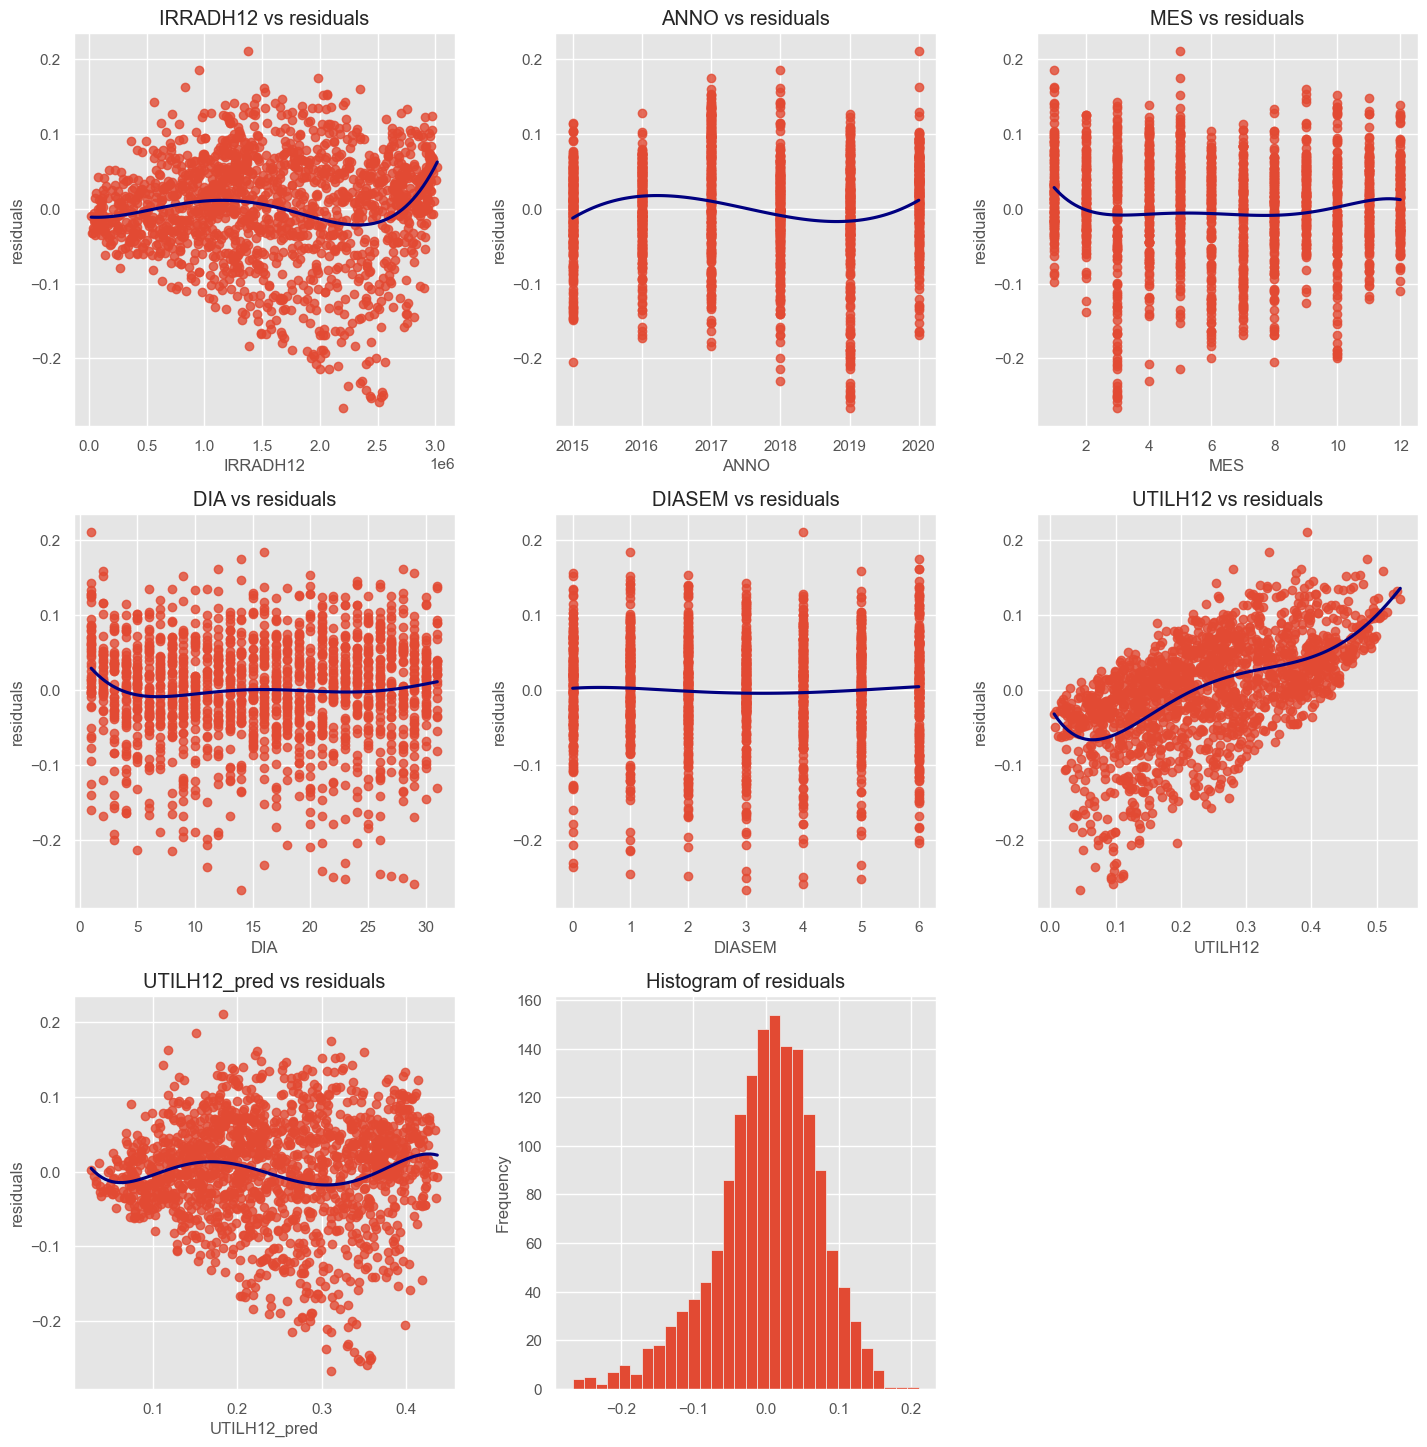

In [13]:
hours = ['12']

for hour in hours:
    inputs_hourly = ['IRRADH' + hour, 'ANNO', 'MES', 'DIA', 'DIASEM']
    output_hourly = 'UTILH' + hour
    pred_hourly   = output_hourly + '_pred'

    dfTR_eval_h = dfTR_eval[inputs_hourly + [output_hourly, pred_hourly]]

    # Analysis of residuals
    RT.plotModelDiagnosis(dfTR_eval_h, pred_hourly, output_hourly, figsize=[15,15])

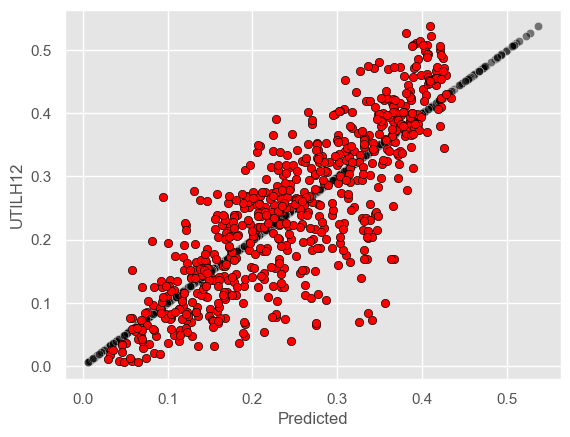

In [14]:
hours = ['12']

for hour in hours:
    inputs_hourly = ['IRRADH' + hour, 'ANNO', 'MES', 'DIA', 'DIASEM']
    output_hourly = 'UTILH' + hour
    pred_hourly   = output_hourly + '_pred'

    # Visualize prediction with respect to real value
    sns.scatterplot(data=dfTS_eval, x = output_hourly, y = output_hourly, color='black', alpha=0.5)
    sns.scatterplot(data=dfTS_eval, x = pred_hourly, y = output_hourly, color='red', edgecolor='black')
    plt.xlabel('Predicted')
    plt.show()